<a href="https://colab.research.google.com/github/zsnoori/NMA_DL_FER/blob/master/NMA_DL_FER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Emotion Recognision
## Nueromatch Academy- Deep Learning course
## Summer 2023
## Pod name: Bellusaurus_line
## Group 2
- Mohammad ([email](mailto:alaeimono@gmail.com) | [GitHub](https://github.com/alaeimo) | [linkedin](https://www.linkedin.com/in/alaeimo/) )
- Zahra ([email](mailto:zs.noori@gmail.com) | [GitHub](https://github.com/zsnoori) | [linkedin](https://linkedin.com/in/zsnoori) )
- Rishabh ([email](mailto:rishabhbapat@gmail.com) | [GitHub](https://github.com/...) | [linkedin](https://linkedin.com/in/...) )
- Vahid ([email](mailto:m1vahid@gmail.com) | [GitHub](https://github.com/...) | [linkedin](https://linkedin.com/in/...) )

## Prepare the requierments

In [ ]:
# @title Install dependencies
%%capture
!pip install torchinfo
!pip install facenet-pytorch
!pip install torch-lr-finder

In [ ]:
# @title Import libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau

import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import models
from torchinfo import summary
from tqdm.notebook import tqdm, trange
import csv
from datetime import datetime
from facenet_pytorch import MTCNN, InceptionResnetV1

In [ ]:
# @title Mount drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


In [ ]:
# @title Set device (GPU or CPU)

# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [ ]:
#@title Plotting Helper Functions
def show_dataloader_batch(dataloader):
  batch = next(iter(dataloader))
  # Extract the images and labels from the batch
  images, labels = batch
  images, labels = images[:20], labels[:20]
  # fig = plt.figure(figsize=(10, 10))
  for i in range(len(images)):
      ax = plt.subplot(4,len(images)//4, i+ 1)
      image = images[i]
      label = labels[i]
      label = label.item()
      if len(image.shape) == 3:
        image = image.permute(1,2,0)
      image = (image * 255).to(torch.uint8)
      ax.imshow(image, cmap="gray")
      ax.set_title(f"{emotions[label]}")
      ax.axis('off')
  plt.tight_layout()
  plt.show()

def show_dataset_batch(dataset, batch_size=20):
  for i in range(batch_size):
      image, label = dataset._samples[i]
      ax = plt.subplot(4, batch_size//4, i+ 1)
      if len(image.shape) == 3:
        image = image.permute(1,2,0)
      ax.imshow(image, cmap="gray")
      ax.set_title(f"{emotions[label]}")
      ax.axis('off')
  plt.tight_layout()
  plt.show()

In [ ]:
set_seed(seed=2021)
device = set_device()


Random seed 2021 has been set.
GPU is enabled in this notebook.


In [ ]:
# @title Set log file path
# Specify the directory path in Google Drive
log_directory = '/content/drive/MyDrive/Colab Notebooks/Logs'
model_directory = os.path.join(log_directory,"Models")
# Check if the directory exists, create it if not
if not os.path.exists(log_directory):
    os.makedirs(log_directory)
    print("Directory created:", log_directory)
else:
    print("Directory already exists:", log_directory)
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
    print("Directory created:", model_directory)
else:
    print("Directory already exists:", model_directory)
log_file_path = os.path.join(log_directory,"log_models.csv")
print("log file path:", log_file_path)
print("models path:", model_directory)

Directory already exists: /content/drive/MyDrive/Colab Notebooks/Logs
Directory already exists: /content/drive/MyDrive/Colab Notebooks/Logs/Models
log file path: /content/drive/MyDrive/Colab Notebooks/Logs/log_models.csv
models path: /content/drive/MyDrive/Colab Notebooks/Logs/Models


In [ ]:
#@title Hyperparameters
#@markdown Define batch_size and dataset_path, image_size, ...
emotions = {0:"Angry", 1:"Disgust", 2:"Fear", 3:"Happy", 4:"Sad", 5:"Surprise", 6:"Neutral"}
emotions_inv = {v:k for k,v in emotions.items()}
torchvision_transforms = True  # True/False if you want use torchvision augmentations
dataset_csv_file = "./drive/MyDrive/Colab Notebooks/datasets/fer2013/icml_face_data.csv"
# mean, std = [0.485, 0.485, 0.485], [0.229, 0.229, 0.229] # ImageNet mean ans std
mean, std = [0.4105, 0.4105, 0.4105], [0.2672, 0.2672, 0.2672] # Calculated mean and std of FER2013
image_size = 224
batch_size = 128

Load and Prepare Dataset

In [ ]:
# @title Dataset class
# @markdown FER2013 dataset includes 3 types of samples, Training, PublicTest, and PrivateTest. This class loads data of each part.

class FER2013(Dataset):
    def __init__(self, csv_file:str, split:str='Training', transforms:transforms.Compose=None):
      """
      Arguments:
          csv_file (string): Path to the FER2013 icml_face_data.csv file with annotations.
          split = 'Training' for train , 'PublicTest' for validation, 'PrivateTest' for test
          transform (callable, optional): Optional transform to be applied on a sample.
      """
      self._main_df = pd.read_csv(csv_file)
      self.split = split
      self.transforms = transforms
      self._samples = self._load()

    def __len__(self):
        return len(self._samples)

    def __getitem__(self, idx):
        img, label = self._samples[idx]
        img = torch.from_numpy(img).float()
        if self.transforms:
            img = self.transforms(img)
        return img, label

    def _load(self):
        df = self._main_df
        df.columns = df.columns.str.replace(' ', '')
        df = df[df['Usage'] == self.split]
        labels = df['emotion'].values
        pixels = df['pixels'].str.split(expand=True).values.astype(int)
        pixels = pixels.reshape(-1, 48, 48)
        samples = list(zip(pixels, labels))
        return samples

In [ ]:
# @title Transformations
# @markdown Define the transformations to apply on our data
transforms_train = transforms.Compose([transforms.ToPILImage()])
if torchvision_transforms:
    transforms_train.transforms.extend([
                transforms.RandomRotation(10),
                transforms.RandomHorizontalFlip(),
                transforms.RandomCrop(size=48, padding=4)])

transforms_train.transforms.extend([
                transforms.Grayscale(num_output_channels=3),
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
                ])

transforms_validation = transforms.Compose([transforms.ToPILImage(),
                                            transforms.Grayscale(num_output_channels=3),
                                            transforms.Resize(image_size),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean, std)
                                            ])

transforms_test = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Grayscale(num_output_channels=3),
                                      transforms.Resize(image_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, std)
                                      ])

In [ ]:
# @title Load data
# @markdown create 3 dataloaders to load Training, validation, and test data.
# Create the dataset
train_dataset = FER2013(csv_file=dataset_csv_file, split='Training', transforms=transforms_train)
validation_dataset = FER2013(csv_file=dataset_csv_file, split='PublicTest', transforms=transforms_validation)
test_dataset = FER2013(csv_file=dataset_csv_file, split='PrivateTest', transforms=transforms_test)

# Create the data loader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train Dataset Samples


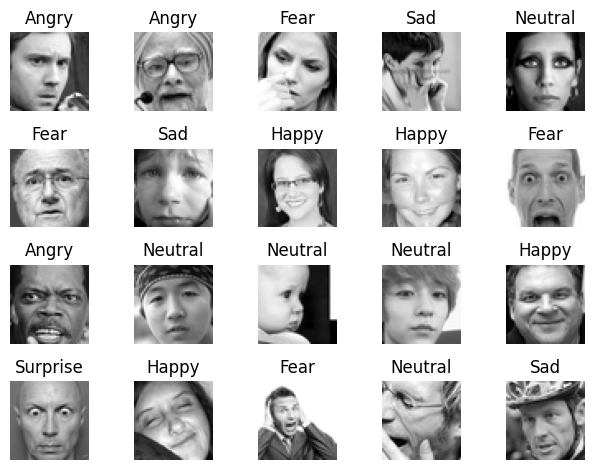

Transformed Train Dataset Samples


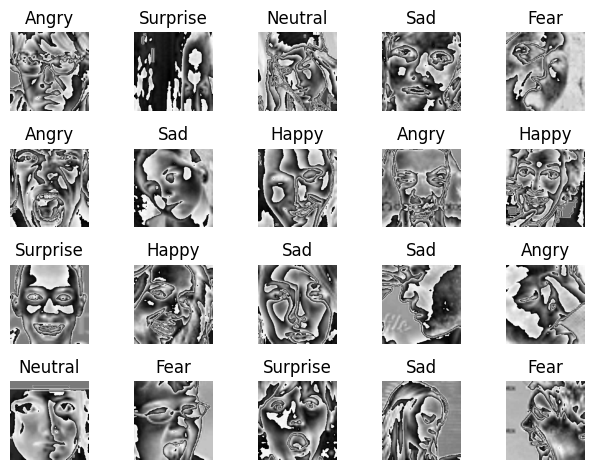

In [ ]:
#@title Plot some samples

print("Train Dataset Samples")
show_dataset_batch(train_dataset)
print("Transformed Train Dataset Samples")
show_dataloader_batch(test_dataloader)

## Models


Pretrained models are models that have been trained on large datasets. By utilizing their learned weights, we can enhance our own models. We can modify or add layers to the pretrained model, enabling us to train a smaller number of parameters during our own training process. This approach helps to leverage existing knowledge and accelerate model training.

Architecture 01: ResNet

In [ ]:
#@title Training, Tesing and Other Helper Functions
def test(model, data_loader, use_cuda=True):
  model.eval()
  test_loss, correct, total = 0, 0, 0
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(data_loader):
      if use_cuda:
        inputs, targets = inputs.cuda(), targets.cuda()

      outputs = model(inputs)
      loss = criterion(outputs, targets)

      test_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      total += targets.size(0)
      correct += predicted.eq(targets.data).cpu().sum()
      del inputs
      del targets
      torch.cuda.empty_cache()
  return (test_loss/batch_idx, 100.*correct/total)

def train(model, epoch, optimizer, criterion, train_dataloader, validation_dataloader=None, use_cuda=True):
  model.train()
  train_loss = 0
  correct = 0
  total = 0
  training_pbar = tqdm(train_dataloader, leave=False)
  for batch_idx, (inputs, targets) in enumerate(training_pbar):
    if use_cuda:
      inputs, targets = inputs.cuda(), targets.cuda()

    optimizer.zero_grad()
    inputs, targets = Variable(inputs), Variable(targets)
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    total += targets.size(0)
    correct += predicted.eq(targets.data).cpu().sum()
    del inputs
    del targets
    torch.cuda.empty_cache()
    desc = f"Epoch: {epoch} Training-Batch: {batch_idx}/{len(train_dataloader)}| Loss: {(train_loss/(batch_idx+1)):0.3f} | Acc: {(100.*correct/total):0.3f}"
    training_pbar.set_description(desc)
  train_loss, train_acc = train_loss/batch_idx, 100.*correct/total
  val_loss, val_acc = 0, 0
  if validation_dataloader:
    val_loss, val_acc = test(model, validation_dataloader, use_cuda=use_cuda)
  return (train_loss, train_acc, val_loss, val_acc)

class History:
    def __init__(self):
        self.train_acc = []
        self.train_loss = []
        self.validation_acc = []
        self.validation_loss = []

    def append_results(self, loss, acc, split):
        if split == "train":
            self.train_loss.append(loss)
            self.train_acc.append(acc)
        if split == "validation":
            self.validation_loss.append(loss)
            self.validation_acc.append(acc)

    def plot(self):
        fig, axes = plt.subplots(1, 2, figsize=(10, 3))
        axes[0].plot(self.train_loss)
        axes[0].plot(self.validation_loss)
        axes[0].set_title("Loss")
        axes[0].legend(["train_loss", "val_loss"])
        axes[1].plot(self.train_acc)
        axes[1].plot(self.validation_acc)
        axes[1].set_ylim(0, 100)
        axes[1].set_title("Accuracy")
        axes[1].legend(["train_acc", "val_acc"])
        plt.tight_layout()
        plt.show()

# checkpoint & adjust_learning_rate
def checkpoint(model, acc, epoch, out_model_name):
  # Save checkpoint.
  print('Saving..')
  state = {
      'state_dict': model.state_dict(),
      'acc': acc,
      'epoch': epoch,
      'rng_state': torch.get_rng_state()
  }
  if not os.path.isdir('checkpoint'):
      os.mkdir('checkpoint')
  torch.save(state, f'./checkpoint/{out_model_name}.t7')

def adjust_learning_rate(optimizer, base_learning_rate, epoch):
  """decrease the learning rate at 1 and 4 epoch"""
  lr = base_learning_rate
  if epoch >= 2:
    lr /= 5
  if epoch >= 4:
    lr /= 5
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr

In [ ]:
# @title log method
def log(hyperparameters, results, text, csv_file_path):
    # Check if CSV file path exists, create it if not
    new_file = False
    if not os.path.exists(csv_file_path):
        new_file = True
        open(csv_file_path, 'w').close()

    # Combine hyperparameters, results, and text into a single list
    data = []
    data.extend(hyperparameters.items())
    data.extend(results.items())
    data.append(('explanation', text))
    data.append(('run_date', datetime.now()))

    # Append data to CSV file
    with open(csv_file_path, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        if new_file: writer.writerow([key for key, _ in data])
        writer.writerow([value for _, value in data])

    print("Results, hyperparameters, and explanation appended to CSV file:", csv_file_path)

In [ ]:
#@title Define Resnet model and download pre-trained weights
torch.cuda.empty_cache()
model = models.resnet18(weights="IMAGENET1K_V1")
# model = InceptionResnetV1(pretrained='vggface2')
# model = models.resnet18()

# Freeze Layers
for param in model.parameters():
  param.requires_grad = True

# Display model summary
# summary(model, input_size=(1, 3, image_size, image_size))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 315MB/s]



Once the weights have been downloaded, we proceed to modify specific layers as needed. By doing so, we can observe the impact on the accuracy of both the training and validation data.

In [ ]:
#@title Change the last Layer:
model.fc = torch.nn.Linear(in_features=512, out_features=7)
# Display model summary
# summary(model, input_size=(1, 3, image_size, image_size))

In [ ]:
#@title Training Hyper-Parameters
base_learning_rate = 1e-03
start_epoch = 0
max_epochs = 20 #10
use_cuda = True if device=='cuda' else False

In [ ]:
#@title Finding a Good Learning Rate
# from torch_lr_finder import LRFinder
# optimizer = optim.Adam(model.parameters(), lr=base_learning_rate)
# criterion = torch.nn.CrossEntropyLoss()
# lr_finder = LRFinder(model, optimizer, criterion, device=device)
# lr_finder.range_test(train_dataloader, end_lr=3, num_iter=100)
# lr_finder.plot()
# lr_finder.reset()

In [ ]:
#@title Optimizer, loss_function and scheduler
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=base_learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, verbose=True)

In [ ]:
#@title Train the model
out_model_name = "resnet18"
history = History()
model.to(device)
# Create a tqdm progress bar
epochs_pbar = trange(start_epoch, max_epochs, leave=True)
for epoch in epochs_pbar:
  train_loss, train_acc, val_loss, val_acc = train(model, epoch, optimizer, criterion, train_dataloader, validation_dataloader, use_cuda=use_cuda)
  history.append_results(train_loss, train_acc, "train")
  history.append_results(val_loss, val_acc, "validation")
  desc_str = f"Epoch: {epoch} | Train Acc: {train_acc:.4f} | Validation Acc: {val_acc:.4f} | Train loss: {train_loss:.4f} | Validation loss: {val_loss:.4f}"
  epochs_pbar.set_description(desc_str)
  scheduler.step(val_loss)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.


  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 00013: reducing learning rate of group 0 to 1.0000e-05.


  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 00019: reducing learning rate of group 0 to 1.0000e-06.


  0%|          | 0/225 [00:00<?, ?it/s]

In [ ]:
test_loss, test_acc = test(model, test_dataloader, use_cuda=use_cuda)
print(f"Test Loss: {test_loss}, Test Acc: {test_acc}")

Test Loss: 1.0510821065732412, Test Acc: 70.07523345947266


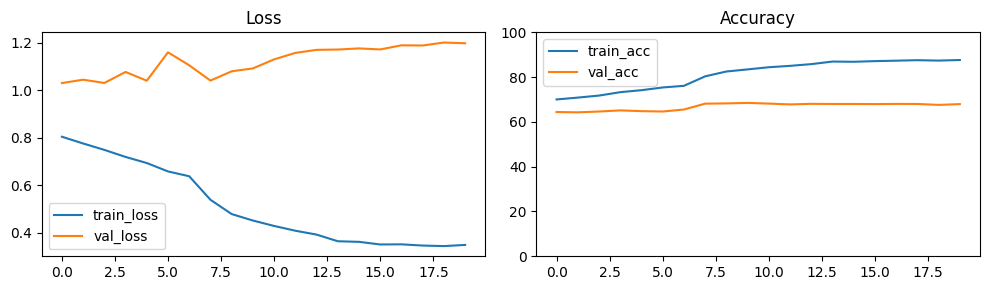

In [ ]:
history.plot()

In [ ]:
# save this training in log file and save the model.
all_hparam = {
    'learning_rate': base_learning_rate,
    'batch_size': batch_size,
    'num_epochs': max_epochs,
    'optimizer' : optimizer,
    'loss_function' : criterion,
}
model_results = {
    'model' : summary(model, input_size=(1, 3, image_size, image_size)),
    'mean_train_loss' : np.mean(history.train_loss),
    'mean_train_acc' : np.mean(history.train_acc),
    'std_train_acc' : np.std(history.train_acc),
    'mean_validation_loss': np.mean(history.validation_loss),
    'mean_validation_acc' : np.mean(history.validation_acc),
    'std_validation_acc' : np.std(history.validation_acc),
    'test_loss': test_loss,
    'test_acc' : test_acc
}
explain_text = "-Add a layer to resnet -Adaprive learning rate"
log(all_hparam,model_results,explain_text,log_file_path)

model_path = os.path.join(model_directory ,f"model-T_acc{test_acc:.2f}-{datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}.pt")
print(model_path)
torch.save(model, model_path)

Results, hyperparameters, and explanation appended to CSV file: /content/drive/MyDrive/Colab Notebooks/Logs/log_models.csv
/content/drive/MyDrive/Colab Notebooks/Logs/Models/model-T_acc70.08-2023-07-24-13-05-11.pt


In [ ]:
print(model_results)

{'model': ==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 7]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             